# **Course: Image Processing and Applications (CS406.Q11)**
**Group ID - Group Name:** 9 - Thăng Sắc 

**Member:** 
- Nguyen Cong Phat - 23521143 (Leader)
- Nguyen Xuan An - 23520023
- Truong Hoang Thanh An - 23520032
- Vu Viet Cuong - 23520213
### **Training U-Net for Fire Segmentation (FLAME Dataset)**

This notebook trains a U-Net model for wildfire segmentation.

In our implementation, we follow standard segmentation practice by applying random data augmentation only during training, while validation and test sets use deterministic preprocessing (resizing only). This ensures fair and reproducible evaluation.

 
**Dataset:** FLAME (semantic segmentation)


## **0. Install libraries**

In [1]:
! pip install segmentation_models_pytorch
! pip install albumentations
! pip install pytorch_lightning 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## **1. Environment & Imports**

In [2]:
import os
import torch
import numpy as np
import cv2
import albumentations as A
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.7.0+cpu
False
0


## **2. Dataset Class**

In [4]:
class FlameDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.image_filenames = sorted(os.listdir(img_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.image_filenames[index])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[index])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, 0)
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug["image"]
            mask = aug["mask"]

        image = np.transpose(image, (2, 0, 1))

        return (
            torch.tensor(image, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.float32),
        )


## **3. Data Augmentation**

In [5]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.RandomScale(scale_limit=(-0.2, 0.2), p=0.3),

    A.RandomBrightnessContrast(0.3, 0.3, p=0.5),
    A.HueSaturationValue(20, 30, 20, p=0.5),
    A.RGBShift(20, 20, 20, p=0.3),

    A.RandomFog(alpha_coef=0.1, p=0.4),
    A.RandomShadow(shadow_roi=(0, 0, 1, 0.5), p=0.4),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),

    A.Resize(512, 512),
], p=1.0)


## **4. Dataset & DataLoader**

In [ ]:
DATA_ROOT = "/mnt/d/flame-dataset"

BATCH_SIZE = 4
NUM_WORKERS = 4
EPOCHS = 50
LR=0.001
DECAY=0.00001
MOMENTUM=0.9

train_dataset = FlameDataset(
    img_dir=f"{DATA_ROOT}/train/images",
    mask_dir=f"{DATA_ROOT}/train/masks",
    transform=transform
)

val_dataset = FlameDataset(
    img_dir=f"{DATA_ROOT}/val/images",
    mask_dir=f"{DATA_ROOT}/val/masks",
    transform=transform
)

test_dataset = FlameDataset(
    img_dir=f"{DATA_ROOT}/test/images",
    mask_dir=f"{DATA_ROOT}/test/masks",
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=True
)


In [7]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(300, 100, 100)

## **5. VISUALIZE SAMPLE DATASET**

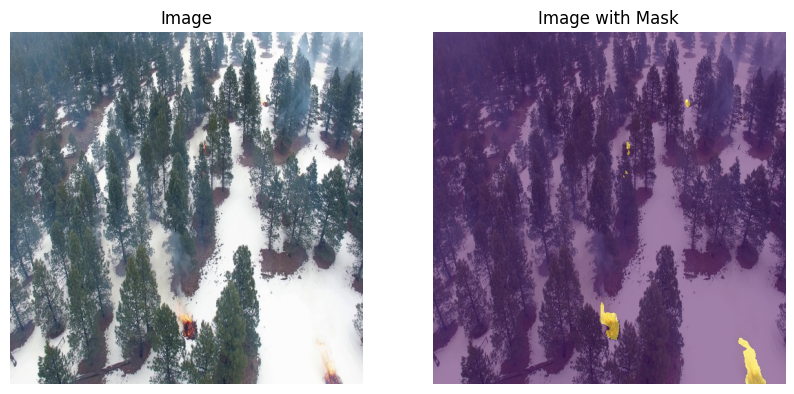

In [8]:
idx = np.random.randint(len(train_dataset))
sample = train_dataset[idx]

image = sample[0].numpy().transpose(1, 2, 0)  #(C, H, W) -> (H, W, C)
mask = sample[1].numpy()

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(image.astype(np.uint8))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image.astype(np.uint8))
plt.imshow(mask, alpha=0.5)
plt.title("Image with Mask")
plt.axis("off")

plt.show()



## **6. Lightning Model (UNet)**

During training, IoU, F1-score, precision, and recall are computed at the end of each epoch using aggregated true positive, false positive, false negative, and true negative statistics. This avoids storing per-batch predictions in memory and ensures stable training on limited-resource environments such as Kaggle.

In [9]:
T_MAX = EPOCHS * len(train_dataloader)


In [10]:
class FlameModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn_dice = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_fn_bce = smp.losses.SoftBCEWithLogitsLoss()
        self.loss_fn_focal = smp.losses.FocalLoss(smp.losses.BINARY_MODE)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        assert image.ndim == 4
        assert mask.ndim == 3, f"Mask should have 3 dimensions, got {mask.ndim}"

        h,w = image.shape[2:]

        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        loss = self.loss_fn_focal(logits_mask, mask) + self.loss_fn_dice(logits_mask, mask) + self.loss_fn_bce(logits_mask, mask.unsqueeze(1))
        # loss = self.loss_fn_bce(logits_mask, mask.unsqueeze(1))
        
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.squeeze().long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_iou": iou,
            f"{stage}_f1_score": f1_score,
            f"{stage}_accuracy:": accuracy,
            f"{stage}_precision:": precision,
            f"{stage}_recall:": recall
        }

        self.log_dict(metrics, prog_bar=True,sync_dist=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

## **7. Train**

In [ ]:
model = FlameModel(
    arch="Unet",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    devices=1
)

trainer.fit(model, train_dataloader, val_dataloader)




💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Unet                  │ 24.4 M │ train │     0 │
│ 1 │ loss_fn_dice  │ DiceLoss              │      0 │ train │     0 │
│ 2 │ loss_fn_bce   │ SoftBCEWithLogitsLoss │      0 │ train │     0 │
│ 3 │ loss_fn_focal │ FocalLoss             │      0 │ train │     0 │
└───┴───────────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 24.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.4 M                                                                                               
Total estimated model params size (MB): 97                                                                         
Modules in train mode: 191                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

c:\Users\NguyenCongPhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connect
ors\data_connector.py:429: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the 
dataloader worker initialization.

In [ ]:
print("Validation metrics:")
print(trainer.validate(model, dataloaders=val_dataloader))

print("Test metrics:")
print(trainer.test(model, dataloaders=test_dataloader))